<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [8]</a>'.</span>

## Global signal basic calibration
_Phil Bull, 2023-01-11_

This uses simple differencing, averaging, and smoothing to derive estimates of the bandpass, time-dependent gains, and noise-wave parameters.

In [1]:
import numpy as np
import scipy.optimize
import pylab as plt
import h5py

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern

plt.rcParams["figure.figsize"] = (10, 5)

np.seterr(all="warn")

# matshow can only plot real, so convert complex values. Dunno if this is appropriate. Maybe should be np.real
check_c = lambda a: a if not isinstance(a[0, 0], complex) else np.abs(a)     

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Settings


fname = "sim_global_"+"BEAM_SPEC"+"_refl.uvh5"  

## Calibration assumptions
Values assumed for the calibration loads and noise diode.

In [3]:
# Calibration source assumed temperatures
Tdiode = 60. # K
Tload1 = 293. # K
Tload2 = 393. # K

# How often diode/load are switched in
# Noise diode
diode_cadence = 10
diode_duration = 2

# Load 1
load1_cadence = 200
load1_duration = 10
load1_offset = 50

# Load 2
load2_cadence = 200
load2_duration = 10
load2_offset = 100

## Load data

In [4]:
with h5py.File(fname, 'r') as f:
    
    # Print datasets and attributes
    for field in f.keys():
        print(field)
        for attr in f[field].attrs.keys():
            print("  | %s: %s" % (attr, f[field].attrs[attr]))
    
    # Load data
    d = np.array(f['data'][:])
    d_nodiode = np.array(f['data_nodiode'][:])
    d_onlydiode = np.array(f['data_onlydiode'][:])
    load1 = np.array(f['data_load1'][:])
    load2 = np.array(f['data_load2'][:])
    ndiode_mask = np.array(f['ndiode_mask'][:])
    
    # Reflection coeffs
    Gamma_rec = np.array(f['data_Gamma_rec'][:])
    Gamma_src = np.array(f['data_Gamma_src'][:])
    
    # Freqs/times
    freqs = np.array(f['freqs'][:])
    times = np.array(f['times'][:])
    lsts = np.array(f['lsts'][:])
    
    # Metadata
    obstime = str(f['data'].attrs['obstime'])
    location = str(f['data'].attrs['location'])
    Tdiode = float(f['ndiode_mask'].attrs['Tdiode_Kelvin'])
    
print("")
print("Data shape:", d.shape)
print("Obstime:   ", obstime)
print("Location:  ", location)
print("")
print("Freqs: %6.3f - %6.3f MHz (%d)" % (freqs[0], freqs[-1], freqs.size))
print("LSTs:  %6.3f - %6.3f rad (%d)" % (lsts[0], lsts[-1], lsts.size))
print("Times: %6.3f - %6.3f sec (%d)" % (times[0], times[-1], times.size))

data
  | location: (3822712.88544561, -153832.37979807, 5086301.58702797) m
  | obstime: 2022-10-21 07:59:59.712
  | site_height_m: 77.0
  | site_lat_deg: 53.235002
  | site_lon_deg: -2.3044349
  | units: K
data_Gamma_rec
data_Gamma_src
data_load1
data_load2
data_nodiode
data_onlydiode
freqs
  | units: MHz
lsts
  | units: rad
ndiode_mask
  | Tdiode_Kelvin: 60.0
times
  | units: s

Data shape: (3600, 280)
Obstime:    2022-10-21 07:59:59.712
Location:   (3822712.88544561, -153832.37979807, 5086301.58702797) m

Freqs: 60.000 - 88.000 MHz (280)
LSTs:   2.573 -  3.098 rad (3600)
Times:  0.000 - 7200.000 sec (3600)


## Switching/sampling strategy
Masks that determine when the noise diode and calibration sources are switched in.

In [5]:
def regular_mask(times, cadence, duration, offset=0):
    """
    Construct a mask that has regular structure.
    
    Parameters:
        times (array_like):
            Time sample array.
        cadence (int):
            How often the mask is switched on (no. of samples).
        duration (int):
            How long the mask is switched on for (no. of samples). 
        offset (int):
            Number of samples before the first time the mask is 
            switched on.
    
    Returns:
        mask (array_like):
            Array of integers, 1 or 0.
    """
    mask = np.zeros(times.size, dtype=int)
    for i in range(duration):
        mask[offset+i::cadence] = 1
    return mask

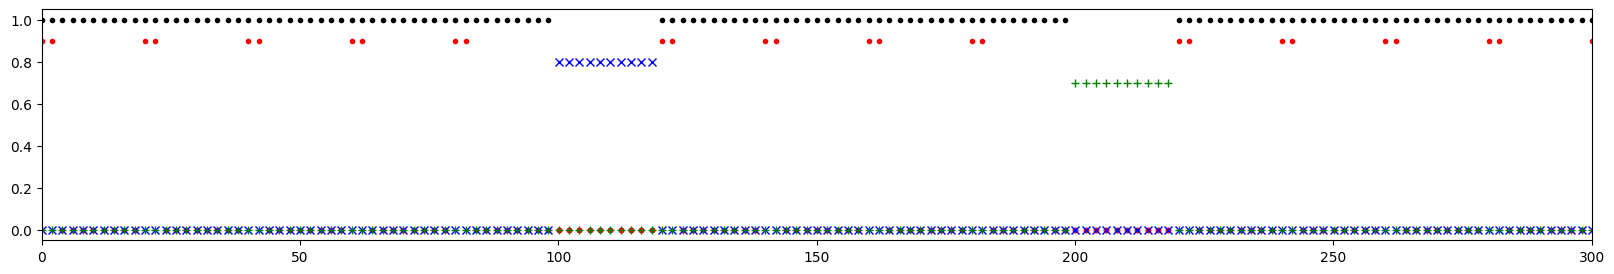

In [6]:
# Noise diode
diode_cadence = 10
diode_duration = 2
mask_ndiode = regular_mask(times, cadence=diode_cadence, duration=diode_duration).astype(bool)

# Load 1
load1_cadence = 200
load1_duration = 10
load1_offset = 50
mask_load1 = regular_mask(times, cadence=load1_cadence, duration=load1_duration, offset=load1_offset).astype(bool)

# Load 2
load2_cadence = 200
load2_duration = 10
load2_offset = 100
mask_load2 = regular_mask(times, cadence=load2_cadence, duration=load2_duration, offset=load2_offset).astype(bool)

# Switch off data (and diode) when load 1 or load 2 is switched in
mask_data = np.ones(times.size, dtype=int).astype(bool)
mask_data[np.logical_or(mask_load1 == True, mask_load2 == True)] = False
mask_ndiode[np.logical_or(mask_load1 == True, mask_load2 == True)] = False

# Plot mask
plt.plot(times, mask_data, 'k.')
plt.plot(times, mask_ndiode*0.9, 'r.')
plt.plot(times, mask_load1*0.8, 'bx')
plt.plot(times, mask_load2*0.7, 'g+')

plt.xlim((0, 300))
plt.gcf().set_size_inches((20., 3.))

## Construct TOD for this switching/sampling strategy

In [7]:
# Combine data from each source into a single timestream
data = np.zeros_like(d)
data[mask_data,:] = d_nodiode[mask_data,:]
data[mask_ndiode,:] += d_onlydiode[mask_ndiode,:]
data[mask_load1,:] = load1[mask_load1,:]
data[mask_load2,:] = load2[mask_load2,:]

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

TypeError: Image data of dtype complex128 cannot be converted to float

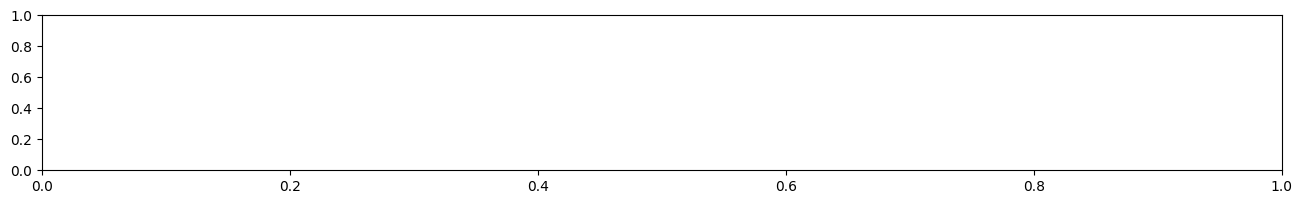

In [8]:
plt.matshow(check_c(data.T), aspect='auto')
plt.colorbar()
plt.gcf().set_size_inches((20., 6.))

## Bandpass estimates
Here, we use the noise diode and calibration loads to derive different bandpass estimates.


### Noise diode
The noise diode estimate is differential; we difference between the diode-OFF and diode-ON states at the start and end of the diode-ON periods. The height of this difference should be:

$\Delta P \approx g(\nu, t)\, T_{\rm diode}(\nu, t)\, (1 - |\Gamma_{\rm src}|^2) |\kappa|^2$.

This assumes that the gain, diode temperature, and reflections do not change appreciably between time samples.

In [ ]:
def get_chunks(diode_mask):
    ndiode_on_chunks = []
    ndiode_off_chunks = []
    cur_chunk = []
    cur_state = diode_mask[0] # start in the initial state
    
    # Loop over mask elements
    for i in np.arange(diode_mask.size):
        if diode_mask[i] == cur_state:
            # Still in the previous chunk
            cur_chunk.append(i)
        else:
            # New chunk has started; flush the old chunk
            if cur_state == 1:
                ndiode_on_chunks.append(np.array(cur_chunk))
            else:
                ndiode_off_chunks.append(np.array(cur_chunk))
            
            cur_state = diode_mask[i]
            cur_chunk = []
            cur_chunk.append(i)
            
    return ndiode_on_chunks, ndiode_off_chunks

# Get continguous blocks of times where the noise diode is on and off
ndiode_on, ndiode_off = get_chunks(mask_ndiode)

In [ ]:
# Calculate bandpass by differencing between neighbouring ON- and OFF-state time 
# samples, for only the leading and trailing samples of the diode-on block
deltas = [] # difference between ndiode on and off states (neighbouring time samples)
t_deltas = [] # time at the boundary between the states
for block in ndiode_on:
    
    if block[0] != 0:
        delta_leading = d[block[0]] - d[block[0]-1]
        deltas.append(delta_leading)
        t_deltas.append(0.5 * (times[block[0]] + times[block[0]-1]))
    
    if block[-1] != times.size-1:
        delta_trailing = d[block[-1]] - d[block[-1]+1]
        deltas.append(delta_trailing)
        t_deltas.append(0.5 * (times[block[-1]] + times[block[-1]+1]))

# Convert to numpy arrays
t_deltas = np.array(t_deltas)
deltas = np.array(deltas)

In [ ]:
# Calculate median and standard deviation
bandpass_ndiode_median = np.median(deltas, axis=0)
bandpass_ndiode_std = np.std(deltas, axis=0)

In [ ]:
# Use each difference to get a bandpass estimate
# NOTE: This does not factor out the time-dependent gain yet!
cmap = plt.get_cmap("plasma")
for i in range(deltas.shape[0]):
    plt.plot(freqs, deltas[i], color=cmap(i/deltas.shape[0]), alpha=0.1)

plt.plot(freqs, bandpass_ndiode_median, 'k-', lw=1.8)
plt.plot(freqs, bandpass_ndiode_median + bandpass_ndiode_std, 'k:', lw=1.8)
plt.plot(freqs, bandpass_ndiode_median - bandpass_ndiode_std, 'k:', lw=1.8)
    
plt.xlabel("Freq. [MHz]", fontsize=16)
plt.ylabel("$\Delta P$ [arb. units]", fontsize=16)
plt.tick_params(which='both', size=6., labelsize=14)
plt.gcf().set_size_inches((12., 6.))

In [ ]:
# If we assume that the bandpass is perfectly stable in time, we can derive a time-dep. 
# gain in each frequency channel
_gain_est = deltas / np.median(deltas, axis=0)

# Get mean (ignore edge channels, which give NaN)
_gain_est_mean = np.mean(_gain_est[:,1:-1], axis=1)

plt.subplot(111)
plt.plot(t_deltas, _gain_est, 'y-', alpha=0.1)
plt.plot(t_deltas, _gain_est_mean, 'r-')

plt.ylabel("Time-dep. gain (rescaled)", fontsize=16)
plt.xlabel("Time [s]", fontsize=16)
plt.tick_params(which='both', size=6., labelsize=14)
plt.gcf().set_size_inches((20., 5))

In [ ]:
def fit_gaussian_process(t, t_samp, y, corrscale1=0.005, corrscale2=0.1, verbose=True):
    """
    For a smooth Gaussian Process to a set of data points. Useful as 
    an interpolator.
    
    The GP kernel is taken to be the sum of a WhiteKernel, and two RBF 
    kernels with different correlation scales.
    
    Parameters:
        t (array_like):
            Set of times/sample points to interpolate onto.
        t_samp (array_like):
            Set of times/points that the input data were measured at.
        y (array_like):
            Values of the input data at the sample points.
        corrscale1, corrscale2 (float):
            Initial guesses for the correlation scales of the two RBF kernels.
        verbose (bool):
            Whether to print basic information about the GP fits.
    
    Returns:
        y_pred (array_like):
            Predicted values of the data at the sample points given by `t'.
        y_samp (array_like):
            Predicted values at the input sample points.
    """
    # Construct kernel
    kernel = WhiteKernel() + RBF(corrscale1) + RBF(corrscale2)

    # Rescale time coords
    X = np.atleast_2d(t_samp[:]).T / np.max(t_samp)
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=0).fit(X, y)
    if verbose:
        print("GPR score (train): %5.3f" % gpr.score(X, y))

    # Predict for trailing-edge samples
    X2 = np.atleast_2d(times).T / np.max(t_samp)
    y2 = gpr.predict(X2, return_std=False)
    y1 = gpr.predict(X, return_std=False)
    if verbose:
        print(gpr.kernel_)
    return y2, y1

In [ ]:
# Apply Gaussian Process smoothing to interpolate over noisy estimate of time-dep. gain
gain_est_mean_gpfit, gain_est_mean_gpfit_tdelta = fit_gaussian_process(times, t_deltas, _gain_est_mean)

# Plot noisy gain estimate and GP-smoothed, interpolated version
plt.subplot(111)
plt.plot(t_deltas, _gain_est_mean, 'k.', lw=1.8)
plt.plot(times, gain_est_mean_gpfit, 'r-', lw=1.2)
#plt.xlim((0., 1000.))

plt.ylabel("Time-dep. gain (rescaled)", fontsize=16)
plt.xlabel("Time [s]", fontsize=16)
plt.tick_params(which='both', size=6., labelsize=14)
plt.gcf().set_size_inches((20., 4.))

In [ ]:
# Rescale bandpass samples by time-dependent gains and try averaging again

# Calculate median and standard deviation after rescaling by time-dep. gain factor
bandpass_ndiode_gaincorr_median = np.median(deltas / gain_est_mean_gpfit_tdelta[:,np.newaxis], axis=0)
bandpass_ndiode_gaincorr_std = np.std(deltas / gain_est_mean_gpfit_tdelta[:,np.newaxis], axis=0)

# Use each difference to get a bandpass estimate, now with time-dep. gain factored out
plt.subplot(211)
cmap = plt.get_cmap("plasma")
for i in range(deltas.shape[0]):
    plt.plot(freqs, 
             deltas[i] / gain_est_mean_gpfit_tdelta[i], 
             color=cmap(i/deltas.shape[0]), 
             alpha=0.1)

plt.plot(freqs, bandpass_ndiode_median, 'k-', lw=1.8)
plt.plot(freqs, bandpass_ndiode_median + bandpass_ndiode_std, 'k--', lw=1.8)
plt.plot(freqs, bandpass_ndiode_median - bandpass_ndiode_std, 'k--', lw=1.8)

plt.plot(freqs, bandpass_ndiode_gaincorr_median, 'r--', lw=1.8)
plt.plot(freqs, bandpass_ndiode_gaincorr_median + bandpass_ndiode_gaincorr_std, 'r:', lw=1.8)
plt.plot(freqs, bandpass_ndiode_gaincorr_median - bandpass_ndiode_gaincorr_std, 'r:', lw=1.8)
    
plt.xlabel("Freq. [MHz]", fontsize=16)
plt.ylabel("$\Delta P / g(t)$ [arb. units]", fontsize=16)
plt.tick_params(which='both', size=6., labelsize=14)


plt.subplot(212)
plt.plot(freqs, bandpass_ndiode_median / bandpass_ndiode_gaincorr_median, 'k-', lw=1.8)

plt.xlabel("Freq. [MHz]", fontsize=16)
plt.ylabel(r"$\langle \Delta P \rangle ~/~ \langle \Delta P / g(t) \rangle$ [arb. units]", fontsize=16)
plt.tick_params(which='both', size=6., labelsize=14)

plt.gcf().set_size_inches((12., 10.))

In [ ]:
# Reconstruct (bandpass x time-dep. gain) / Tdiode
gain2d_ndiode = bandpass_ndiode_gaincorr_median[:,np.newaxis] \
              * gain_est_mean_gpfit[np.newaxis,:] \
              / Tdiode

plt.matshow(check_c(gain2d_ndiode), aspect='auto')
plt.colorbar(label="Gain est.")

plt.xlabel("Time sample", fontsize=16)
plt.ylabel("Freq. sample", fontsize=16)
plt.tick_params(which='both', size=6., labelsize=14)

plt.gcf().set_size_inches((18., 4.))

### Calibration loads

We would like to assume that the calibration loads are time- and frequency-stable (i.e. perfectly spectrally flat), and perfectly impedance-matched, so that the measured power is

$P_{\rm load} \approx g(\nu, t)\, T_{\rm load}\, |\kappa|^2 = g(\nu, t)\, T_{\rm load}\, (1 - |\Gamma_{\rm rec}|^2)$.

If we divide through by the assumed temperature of the load, we therefore get an estimate of the bandpass times the receiver reflection coefficient factor.

In [ ]:
# Use calibration loads to get bandpass
load1_on, load1_off = get_chunks(mask_load1)
load2_on, load2_off = get_chunks(mask_load2)

# Extract each set of cal. load observations into an array with the same shape as the data
pload1 = np.zeros_like(data)
for block in load1_on:
    pload1[block,:] = data[block,:]

pload2 = np.zeros_like(data)
for block in load2_on:
    pload2[block,:] = data[block,:]

# Rescale by gain (time-dep. and bandpass)
pload1_scaled = pload1.T / gain2d_ndiode
pload2_scaled = pload2.T / gain2d_ndiode

In [ ]:
# Plot rescaled calibration load values
# (Concatenates the blocks of time samples where the loads are on)
plt.subplot(211)
plt.matshow(check_c(pload1_scaled[:,np.concatenate(load1_on)] - Tload1), 
            aspect='auto', 
            cmap='RdBu', 
            fignum=False,
            vmin=-10.,
            vmax=10.)
plt.colorbar(label="Load 1 $\Delta T$ [K]")

plt.subplot(212)
plt.matshow(check_c(pload2_scaled[:,np.concatenate(load2_on)] - Tload2), 
            aspect='auto', 
            cmap='RdBu', 
            fignum=False,
            vmin=-10.,
            vmax=10.)
plt.colorbar(label="Load 2 $\Delta T$ [K]")

plt.gcf().set_size_inches((20., 6.))

### Reflection coefficient measurements

In [ ]:
plt.subplot(211)
plt.matshow(np.abs(Gamma_rec.T[:,np.concatenate(load2_on)]), 
            aspect='auto', 
            cmap='cividis', 
            fignum=False
            )
plt.colorbar(label=r"$\Gamma_{\rm rec}$")

plt.subplot(212)
plt.matshow(np.abs(Gamma_src.T[:,np.concatenate(load2_on)]), 
            aspect='auto', 
            cmap='cividis', 
            fignum=False,
            )
plt.colorbar(label=r"$\Gamma_{\rm src}$")

plt.gcf().set_size_inches((20., 6.))